In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os,torch
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir(r'/content/drive/MyDrive/3semester/8160/hw8/')
#RNN GRU LSTM model
from models import MyLSTM, MyGRU, MyRNN

In [ ]:
class TrafficForecast(Dataset):
    def __init__(self,pkl_path, window, horizon):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.inputs = []
        self.targets = []


        df = pd.read_pickle(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)
        # self.seg_ids = self.df['segmentID'].unique()
        self.seg_ids = self.df['time'].unique()
        self.setup_forecast()

    def setup_forecast(self):
        for segid in self.seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time',ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill") # 1 nan nan nan 2, fulfill 2
            TI_series = df_seg_id['TrafficIndex_GP'].values
            h_series = df_seg_id['hour'].values
            #split it into training and test 80 20
            for t in range(0,len(TI_series)-(self.window+self.horizon)):
                x = TI_series[t:t+self.window]
                y = TI_series[t+self.window:(t+self.window+self.horizon)]
                h = h_series[t:t+self.window]
                x_cat = np.dstack([x, h])
                self.inputs.append(x_cat)
                self.targets.append(y)

    def __len__(self):
        return len(self.inputs)


    def __getitem__(self,idx):
        X = torch.tensor(self.inputs[idx],dtype=torch.float32).reshape(self.window, 2)
        y=torch.tensor(self.targets[idx],dtype=torch.float32)

        return {'inputs':X,'outputs':y}

class ToTensor(object):
    def __call__(self, bs,window, horizon,sample):
        input, output = sample['inputs'], sample['outputs']

        return {'inputs': torch.tensor(np.array(input),dtype=torch.float32).reshape(bs,window,-1),
                'outputs': torch.tensor(np.array(output),dtype=torch.float32).reshape(bs,horizon,-1)}

In [ ]:
tobj = TrafficForecast('tps_df.pkl',36,12) #window and forcast

In [ ]:
bs = 1024
dataloader_train = DataLoader(tobj, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

In [ ]:
#batch_size, sequence_length, feature_dim(traffic index and hour)

for idx, data in enumerate(dataloader_train):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx == 3:
        break

torch.Size([1024, 36, 2]) torch.Size([1024, 12])
torch.Size([1024, 36, 2]) torch.Size([1024, 12])
torch.Size([1024, 36, 2]) torch.Size([1024, 12])
torch.Size([1024, 36, 2]) torch.Size([1024, 12])


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LSTM

In [ ]:
model = MyLSTM(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=12)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.0494
Epoch 2/3, Training Loss: 0.0302
Epoch 3/3, Training Loss: 0.0236


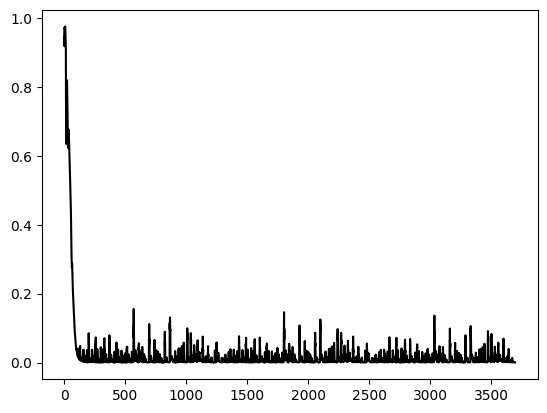

In [ ]:
plt.plot(losses,'k',label='training')

In [ ]:
torch.save(model.state_dict(), 'MyLSTM.pt')

GRU

In [ ]:
model1 = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=12)
model1.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model1(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.0554
Epoch 2/3, Training Loss: 0.0333
Epoch 3/3, Training Loss: 0.0259


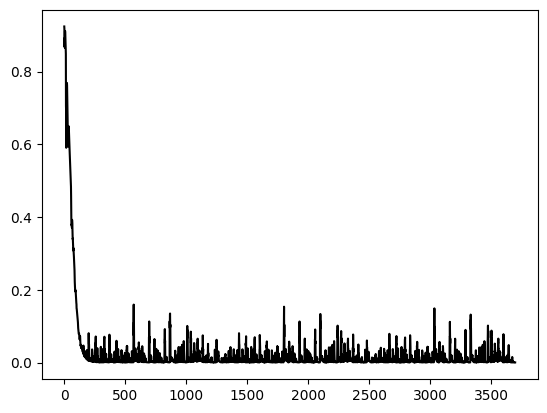

In [ ]:
plt.plot(losses,'k',label='training')

In [ ]:
torch.save(model1.state_dict(), 'Mygru.pt')

RNN

In [ ]:
model2 = MyRNN(input_size=2, hidden_size=10, num_layers=2,output_size=12, bias=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model2(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.0816
Epoch 2/3, Training Loss: 0.0451
Epoch 3/3, Training Loss: 0.0328


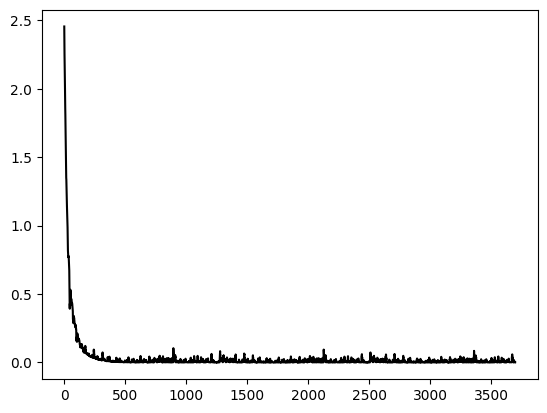

In [ ]:
plt.plot(losses,'k',label='training')

In [ ]:
torch.save(model2.state_dict(), 'Myrnn.pt')

Test Data

In [6]:
tps_1 = pd.read_pickle('Copy of tps_1.pkl')
tps_1.fillna(0, inplace=True)
tps_1


,index,time,segmentID,AVG_Spd_GP,AVG_Spd_HOV,AVG_Vol_GP,AVG_Vol_HOV,TrafficIndex_GP,TrafficIndex_HOV
0,1507518,2020-06-01 21:15:00.000,11,64.82,65.0,6.99,1.07,0.994,1.0
1,1507519,2020-06-01 21:15:00.000,12,65.00,65.0,4.98,0.63,1.000,1.0
2,1507520,2020-06-01 21:15:00.000,13,65.00,65.0,4.78,0.95,1.000,1.0
3,1507521,2020-06-01 21:15:00.000,14,65.00,65.0,4.55,1.19,1.000,1.0
4,1507522,2020-06-01 21:15:00.000,15,65.00,65.0,5.01,1.12,1.000,1.0
...,...,...,...,...,...,...,...,...,...
3127,1511209,2020-06-02 06:00:00.000,100,65.00,0.0,11.00,0.00,1.000,0.0
3128,1511211,2020-06-02 06:00:00.000,102,65.00,0.0,3.78,0.00,1.000,0.0
3129,1511212,2020-06-02 06:00:00.000,103,65.00,0.0,5.03,0.00,1.000,0.0
3130,1511213,2020-06-02 06:00:00.000,104,65.00,0.0,4.60,0.00,1.000,0.0


In [ ]:
#split test data into test and predict
def predict_with_model(model, start_time_test, end_time_test, start_time_pred, end_time_pred, device):

    start_time_test = pd.Timestamp(start_time_test)
    end_time_test = pd.Timestamp(end_time_test)
    start_time_pred = pd.Timestamp(start_time_pred)
    end_time_pred = pd.Timestamp(end_time_pred)


    test_index = pd.date_range(start=start_time_test, end=end_time_test, freq='15min')
    num_test_samples = len(test_index)
    test_data = np.random.rand(num_test_samples, num_features)

    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)


    model.load_state_dict(torch.load('Myrnn.pt'))
    model.eval()

    with torch.no_grad():
        predictions = model(test_data_tensor)

    predictions = predictions.cpu().numpy()

    pred_index = pd.date_range(start=start_time_pred, end=end_time_pred, freq='15min')
    predictions_df = pd.DataFrame(predictions, index=pred_index, columns=['Prediction'])

    return predictions_df


start_time_test = '2020-06-01 21:15:00'
end_time_test = '2020-06-02 06:00:00'
start_time_pred = '2020-06-02 06:15:00'
end_time_pred = '2020-06-02 09:00:00'

In [12]:
model2 = MyRNN(input_size=2, hidden_size=10, num_layers=2,output_size=12, bias=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [25]:
predictions_df = predict_with_model(model2, start_time_test, end_time_test, start_time_pred, end_time_pred, device)
print(predictions_df)

In [ ]:
bs = 1024
dataloader_test = DataLoader(tobj_test, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

In [ ]:
dataloader_test

In [ ]:
for idx, data in enumerate(dataloader_test):
    print (data['inputs'].shape, data['outputs'].shape)
    if idx == 3:
        break

Evaluation

In [ ]:
#(MSE)

In [ ]:
#(MAPE)

Visualization

In [ ]:
reshaped_tps_df

,11,12,13,14,15,16,17,18,19,20,...,94,95,96,97,99,100,102,103,104,106
TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00.000,1.0,1.0,1.000,1.0,1.0,1.000,1.0,0.997,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-01-01 00:15:00.000,1.0,1.0,0.993,1.0,1.0,1.000,1.0,0.984,1.000,0.997,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-01-01 00:30:00.000,1.0,1.0,1.000,1.0,1.0,0.993,1.0,0.956,0.997,0.995,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-01-01 00:45:00.000,1.0,1.0,1.000,1.0,1.0,0.978,1.0,0.941,0.994,0.988,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.982
2020-01-01 01:00:00.000,1.0,1.0,1.000,1.0,1.0,0.982,1.0,0.940,0.997,0.989,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 22:45:00.000,1.0,1.0,1.000,1.0,1.0,1.000,1.0,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-05-31 23:00:00.000,1.0,1.0,1.000,1.0,1.0,1.000,1.0,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000
2020-05-31 23:15:00.000,1.0,1.0,1.000,1.0,1.0,1.000,1.0,1.000,1.000,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000


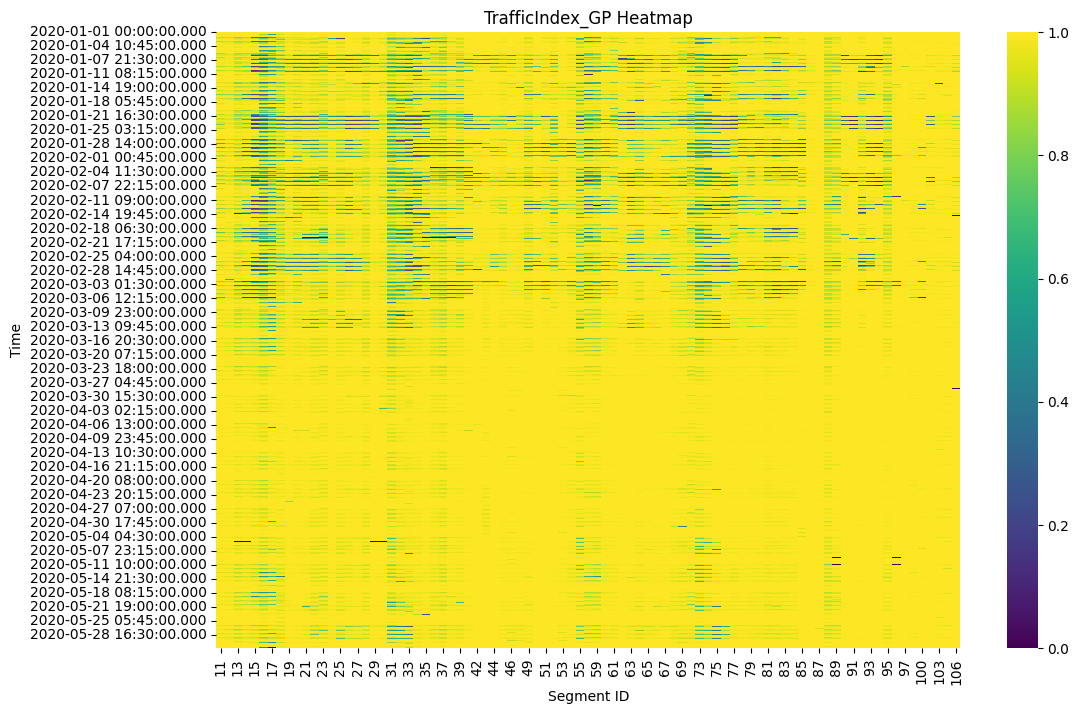

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(reshaped_tps_df, cmap='viridis')
plt.title('TrafficIndex_GP Heatmap')
plt.xlabel('Segment ID')
plt.ylabel('Time')
plt.show()